# Instructions
Download the dataset here: https://archive.ics.uci.edu/ml/datasets/Abalone

The data and variables names are in different files; you will likely need them both. The goal here is to predict the age of the abalone using the other variables in the dataset because the traditional method for aging these organisms is boring and tedious.

```
Attribute information:

   Given is the attribute name, attribute type, the measurement unit and a
   brief description.  The number of rings is the value to predict: either
   as a continuous value or as a classification problem.

	Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		        nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	        continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years
```

There are two challenges (in my opinion):

1. You should try to build the best, bagging-based model (this includes random forests) to predict age.

2. The UC Irvine Machine Learning Repository classifies this dataset as a "classification" dataset, but age is stored as a numeric (albeit discrete-valued) variable. So, I think it could maybe be reasonable to treat this as a regression problem. It's up to you!

Submit your HTML or .ipynb file to canvas.

## Data Import

In [8]:
# Packages
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Data
abalone_df = pd.read_csv('Data/abalone.data', header=None)
abalone_df.columns = [
    'Sex',
    'Length',
    'Diameter',
    'Height',
    'Whole_weight',
    'Shucked_weight',
    'Viscera_weight',
    'Shell_weight',
    'Rings'
]
abalone_df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Data Prep

Based on the metadata, I am going to convert 'Rings' to years and drop 'Rings' (linear transformation). 


In [10]:
# Rings +1.5 gives the age in years
abalone_df["Age"] = abalone_df["Rings"] + 1.5
abalone_df.drop(columns=["Rings"], inplace=True)
abalone_df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


## Bagging Regressor

In [11]:
# Split predictors and target
X = abalone_df.drop(columns='Age')
y = abalone_df['Age']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Column transformer for preprocessing
categorical_features = ['Sex']
categorical_transformer = OneHotEncoder(drop='first')  # avoids dummy variable trap since Sex is 3 categories

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # keeps numeric features as-is
)

# Pipeline: preprocessing + bagging model
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42), random_state=42)),
])

# Grid search
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 250], # B 
    'regressor__estimator__max_depth': [None, 5, 10, 20],
    'regressor__estimator__min_samples_split': [2, 5]
}

# GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_bagging = grid_search.best_estimator_
y_pred = best_bagging.predict(X_test)
mse_bagging = mean_squared_error(y_test, y_pred)
r2_bagging = r2_score(y_test, y_pred)

print(f"Best Params: {grid_search.best_params_}")
print(f"Bagging Test MSE: {mse_bagging:.2f}")
print(f"Bagging Test R²: {r2_bagging:.3f}")

Best Params: {'regressor__estimator__max_depth': 10, 'regressor__estimator__min_samples_split': 2, 'regressor__n_estimators': 250}
Bagging Test MSE: 4.95
Bagging Test R²: 0.543


### KNN for the estimator

In [12]:
from sklearn.neighbors import KNeighborsRegressor

# New pipeline with KNeighborsRegressor as base estimator
knn_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),  # reuse existing transformer
    ('regressor', BaggingRegressor(estimator=KNeighborsRegressor(), random_state=42))
])

# New param grid specific to KNeighbors
knn_param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__estimator__n_neighbors': [3, 5, 7]
}

# GridSearchCV for KNN base learner
knn_grid_search = GridSearchCV(knn_pipe, knn_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

# Predictions and evaluation
best_knn_bagging = knn_grid_search.best_estimator_
y_pred_knn = best_knn_bagging.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Best Params: {knn_grid_search.best_params_}")
print(f"Bagging Test MSE (KNN): {mse_knn:.2f}")
print(f"Bagging Test R² (KNN): {r2_knn:.3f}")

C:\Users\isabe\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: {'regressor__estimator__n_neighbors': 7, 'regressor__n_estimators': 200}
Bagging Test MSE (KNN): 4.87
Bagging Test R² (KNN): 0.550


Both the decision tree and K-nearest neighbors (KNN) base learners performed reasonably well when used within a bagging ensemble, but the KNN model *slightly* outperformed the tree-based model. The optimal parameters for the decision tree ensemble were a maximum depth of 10, minimum samples split of 2, and 250 estimators, resulting in a test MSE of 4.95 and R² of 0.543. In comparison, the KNN ensemble performed best with 7 neighbors and 200 estimators, achieving a lower test MSE of 4.87 and a slightly higher R² of 0.550. This suggests that the KNN-based model captured slightly more variance in the target variable and produced predictions closer to the actual age values on average. The improved performance may be due to the nature of the abalone dataset, where KNN, a non-parametric, locally sensitive method, benefits from averaging over multiple resampled neighborhoods, reducing variance without imposing a rigid structure.

## Random Forest Regressor

In [13]:
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Random Forest hyperparameters
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200, 250],
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__max_features': [None, 'sqrt', 'log2']
}

# Grid search for RF
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Evaluate RF
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Best Params: {grid_rf.best_params_}")
print(f"RF Test MSE: {mse_rf:.2f}")
print(f"RF Test R²: {r2_rf:.3f}")

Best Params: {'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
RF Test MSE: 4.84
RF Test R²: 0.553


The Random Forest model slightly outperformed both the bagged decision tree and bagged K-nearest neighbors (KNN) models. With optimal hyperparameters including a maximum depth of 10, 200 estimators, minimum samples split of 2, and `max_features` set to `'sqrt'`, the Random Forest achieved a test MSE of 4.84 and an R² of 0.553. This represents a small improvement over the bagged decision tree (MSE: 4.95, R²: 0.543) and the bagged KNN (MSE: 4.87, R²: 0.550). The enhanced performance of the Random Forest is likely due to its additional layer of randomness—selecting a subset of features at each split—which reduces correlation among trees and improves generalization. Overall, while all three ensemble models performed similarly, Random Forest proved to be the most effective approach for predicting abalone age in this case, capturing slightly more variance and producing the lowest prediction error.

## Feature Importances

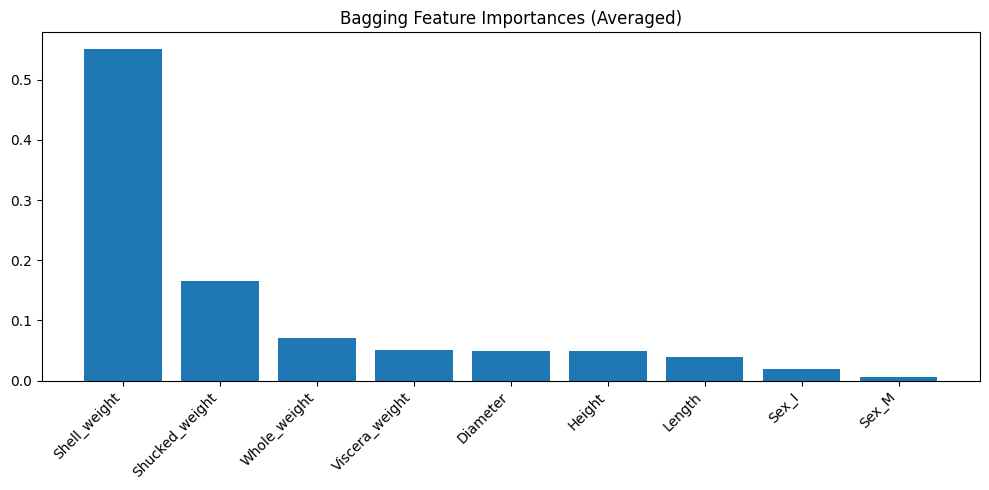

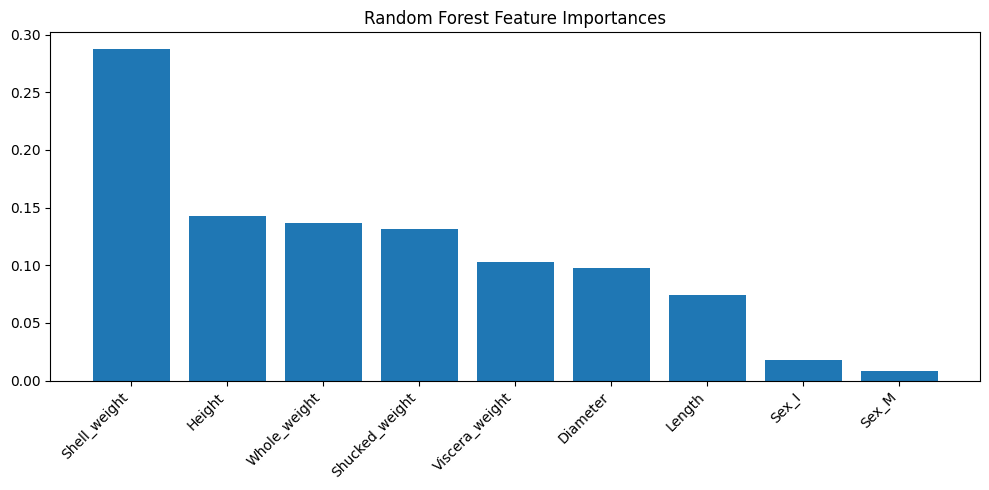

In [14]:
# Retrieve feature names
ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(['Sex'])
all_feature_names = np.concatenate([encoded_feature_names, X.select_dtypes(include=np.number).columns])

# Bagging Feature Importances (averaged over trees)
bagging_model = best_bagging.named_steps['regressor']
importances_bagging = np.mean([
    tree.feature_importances_ for tree in bagging_model.estimators_
], axis=0)

bagging_sorted_idx = np.argsort(importances_bagging)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances_bagging)), importances_bagging[bagging_sorted_idx], align='center')
plt.xticks(range(len(importances_bagging)), all_feature_names[bagging_sorted_idx], rotation=45, ha='right')
plt.title("Bagging Feature Importances (Averaged)")
plt.tight_layout()
plt.show()

# Random Forest Feature Importances
importances_rf = best_rf.named_steps['regressor'].feature_importances_
rf_sorted_idx = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances_rf)), importances_rf[rf_sorted_idx], align='center')
plt.xticks(range(len(importances_rf)), all_feature_names[rf_sorted_idx], rotation=45, ha='right')
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

The feature importance plots reveal that the bagging model heavily relies on a single predictor, with Shell weight accounting for over half of the total importance, while other features contribute minimally. This suggests the model may be overfitting to that dominant variable. In contrast, the random forest model distributes importance more evenly across several features, including Height, Whole weight, Shucked weight, and Viscera weight, in addition to Shell weight. This more balanced reliance is a result of random forest’s use of feature subsampling (`max_features='sqrt'`), which encourages diversity in tree splits and reduces over-dependence on any one feature. This not only enhances model robustness but also likely contributes to its slightly better performance compared to the plain bagged trees.